In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import soundfile as sf
import IPython.display as ipd
from IPython.display import Audio

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
class Filter(object):
    def __init__(self, fc=0.5, gain=1.0, q=1.0, fs=1, filterType='RBPF'):
        self.fc = fc
        self.gain = gain
        self.q = q
        self.fs = fs

        self.z1 = 0
        self.z2 = 0

        if filterType=='RBPF':
            self.B, self.A = self.designRBPF(self.fc, self.q, self.gain, self.fs)
        elif filterType=='LSF':
            self.B, self.A = self.designLSF(self.fc, self.gain, self.fs)
        elif filterType=='HSF':
            self.B, self.A = self.designHSF(self.fc, self.gain, self.fs)

    def designRBPF(self, fc, q, gain, fs):
        # convert center frequency to radians per second
        # TODO Question 1c: modify this line to prewarping the center frequency

        # old line: Convert center frequency from Hz to radians per second (not pre-warped)
        omega_c = 2 * np.pi * fc

        # sample rate
        T = 1/fs

        #Prewarping
        omega_c_warped = (2/T) * np.tan(omega_c * T/2)

        # analog filter coefficients for boost and cut
        if np.abs(gain) >= 1.:
            # TODO Question 1b: modify these lines to implement a parametric boost filter
            Bs = np.array([1 / (omega_c_warped ** 2), gain / (q * omega_c_warped), 1])
            As = np.array([1 / (omega_c_warped ** 2), 1 / (q * omega_c_warped), 1])
        else:
            # TODO Question 1d: modify these lines to implement a parametric cut filter
            Bs = np.array([1 / (omega_c_warped ** 2), 1 / (q * omega_c_warped), 1])
            As = np.array([1 / (omega_c_warped ** 2), 1 / (q * gain * omega_c_warped), 1])

        # convert analog coefficients to digital coefficients using the bilinear transform
        Bz, Az = self.bilinearTransform(Bs, As, fs)

        # output are the digital coefficients for a parametric boost/cut filter
        return Bz, Az

    def designLSF(self, fc, gain, fs):
        # convert center frequency to radians per second
        # TODO Question 2a:  make sure to prewarp your cutoff frequency
        omega_c = 2 * np.pi * fc

        # sample rate
        T = 1/fs

        #Prewarping
        omega_c_warped = (2/T) * np.tan(omega_c * T/2)

        # TODO Question 2a: modify these lines to implement a 1st order low shelf filter
        Bs = np.array([1/omega_c_warped, gain, 0])
        As = np.array([1/ omega_c_warped, 1, 0])


        Bz, Az = self.bilinearTransform(Bs, As, fs)

        return Bz, Az

    def designHSF(self, fc, gain, fs):

        # convert center frequency to radians per second
        # TODO Question 2b:  make sure to prewarp your cutoff frequency
        omega_c = 2 * np.pi * fc

        # sample rate
        T = 1/fs

        #Prewarping
        omega_c_warped = (2/T) * np.tan(omega_c * T/2)

        # TODO Question 2b: modify these lines to implement a 1st order high shelf filter

        Bs = np.array([gain/ omega_c_warped, 1, 0])
        As = np.array([1/ omega_c_warped, 1, 0])

        Bz, Az = self.bilinearTransform(Bs, As, fs)

        return Bz, Az

    # def bilinearTransform(self, Bs, As, fs):
    #     return sig.bilinear(Bs, As, fs)

    def bilinearTransform(self, Bs, As, fs):
        # useful to have sample period and sample period squared
        T = 1.0/fs
        k = 2/T

        # unpack analog coefficients for readability
        bs0 = Bs[0]
        bs1 = Bs[1]
        bs2 = Bs[2]
        as0 = As[0]
        as1 = As[1]
        as2 = As[2]

        # TODO Question 1b: implement the biliner transform to convert an analog
        #                   biquad filter into a digital biquad filter
        az0 = 1.
        az1 = (2 * as2 - 2 * as0 * (k**2)) / (as0 * (k**2) + as1 * k + as2)
        az2 = (as0 * (k**2) - as1 * k + as2)/(as0 * (k**2) + as1 * k + as2)
        bz0 = (bs0 * (k**2) + bs1 * k + bs2) / (as0 * (k**2) + as1 * k + as2)
        bz1 = (2 * bs2 - 2 * bs0 * (k**2)) / (as0 * (k**2) + as1 * k + as2)
        bz2 = (bs0 * (k**2) - bs1 * k + bs2) / (as0* (k**2) + as1 * k + as2)

        # repack digital coefficients into arrays
        Bz = np.array([bz0, bz1, bz2])
        Az = np.array([az0, az1, az2])
        return Bz, Az


    def process(self, input_signal):
        # Initialize the output array with zeros of the same shape as input
        output = np.zeros_like(input_signal)
        # Initialize the boundary conditions
        output[-1] = output[-2] = 0
        for i in range(len(input_signal)):
            # Apply the biquad difference equation found on wiki https://en.wikipedia.org/wiki/Digital_biquad_filter
            output[i] = (
                self.B[0] * input_signal[i] +
                self.B[1] * self.z1 +
                self.B[2] * self.z2 -
                self.A[1] * output[i - 1] -
                self.A[2] * output[i - 2]
            ) / self.A[0]
            # Update the values
            self.z2 = self.z1
            self.z1 = input_signal[i]

        return output

    def reset(self):
        # reset the state of the filter by zeroing out the past output samples
        self.z1 = 0
        self.z2 = 0

Q1. Analog prototype for a peaking filter (DC and Nyquist tend towards 1, gain of gamma at center frequency)
$$
H(s) = \frac
{\left(\frac{s}{\omega_c}\right)^2 + \frac{1}{Q}\gamma \left(\frac{s}{\omega_c}\right) + 1}
{\left(\frac{s}{\omega_c}\right)^2 + \frac{1}{Q} \left(\frac{s}{\omega_c}\right) + 1}
$$

$Q = 2^n$, $\omega_c = 2\pi \cdot 1000$, and $\gamma=2$ for $n = -4, -3, ..., 1, 2$

$Q = 2$, $\omega_c = 2\pi \cdot 1000 \cdot 2^n $, and $\gamma=2$ for $n = -2, 1, 0, 1, 2$

In [ ]:
fs = 44100
NFFT = 1024


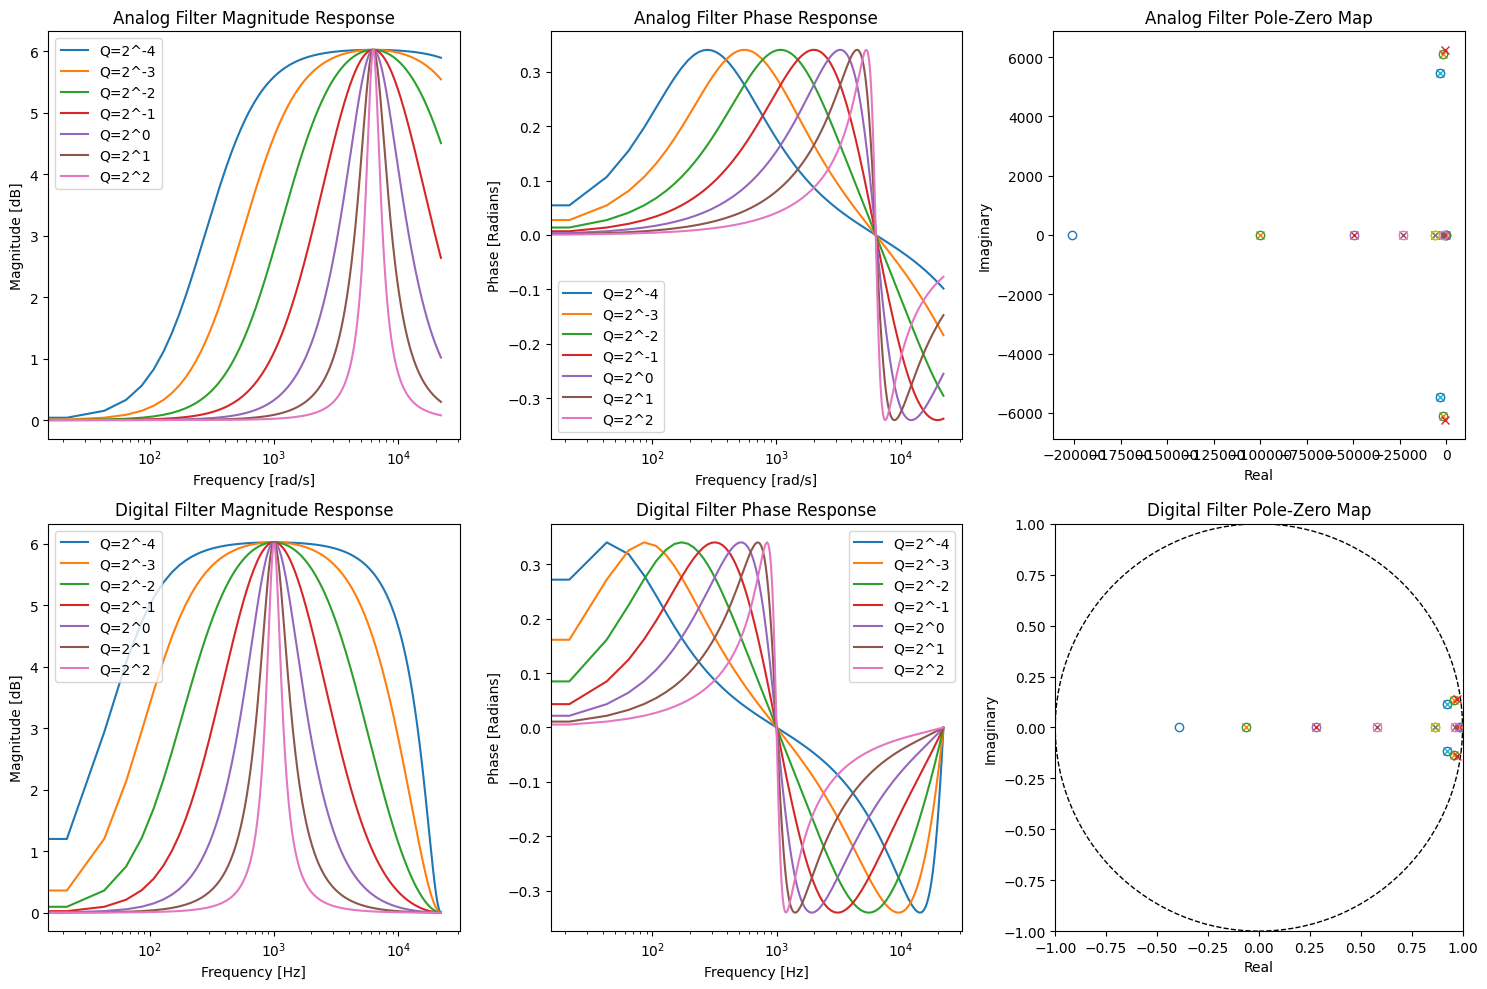

In [ ]:
plt.figure(figsize=(15, 10))
M = np.arange(-4,3)
# Loop through each value of Q, defined as 2^n
for n in M:
    Q = 2. ** n
    wc = 2 * np.pi * 1000
    gamma = 2.  # Gain

    # Prewarp the cutoff frequency
    wc_pre_warped = (2 * fs) * np.tan(wc / (2 * fs))

    # Define the analog filter coefficients
    b = np.array([1./(wc_pre_warped*wc_pre_warped), gamma/(Q*wc_pre_warped), 1.])
    a = np.array([1./(wc_pre_warped*wc_pre_warped), 1.0/(Q*wc_pre_warped), 1.])

    # Compute the analog filter frequency response
    w, H = sig.freqs(b, a, worN=np.linspace(0, fs/2, NFFT))

    # Compute poles and zeros for the analog filter
    z = np.roots(b)
    p = np.roots(a)

    # Convert analog filter coefficients to digital using the bilinear transform
    bz, az = sig.bilinear(b, a, fs)

    # Compute the digital filter frequency response
    wz, Hz = sig.freqz(bz, az, worN=NFFT)

    # Compute poles and zeros for the digital filter
    zz = np.roots(bz)
    pz = np.roots(az)

    # Plot the magnitude response of the analog filter
    plt.subplot(2, 3, 1)
    plt.plot(w, 20 * np.log10(np.abs(H)), label=f'Q=2^{n}')
    plt.xscale('log')
    plt.title('Analog Filter Magnitude Response')
    plt.xlabel('Frequency [rad/s]')
    plt.ylabel('Magnitude [dB]')
    plt.legend()

    # Plot the phase response of the analog filter
    plt.subplot(2, 3, 2)
    plt.plot(w, np.angle(H), label=f'Q=2^{n}')
    plt.xscale('log')
    plt.title('Analog Filter Phase Response')
    plt.xlabel('Frequency [rad/s]')
    plt.ylabel('Phase [Radians]')
    plt.legend()

    # Plot the pole-zero map of the analog filter
    plt.subplot(2, 3, 3)
    plt.plot(np.real(z), np.imag(z), 'o', markerfacecolor="none")
    plt.plot(np.real(p), np.imag(p), 'x')
    plt.title('Analog Filter Pole-Zero Map')
    plt.xlabel('Real')
    plt.ylabel('Imaginary')

    # Plot the magnitude response of the digital filter
    plt.subplot(2, 3, 4)
    plt.plot(wz * (fs / (2 * np.pi)), 20 * np.log10(np.abs(Hz)), label=f'Q=2^{n}')
    plt.xscale('log')
    plt.title('Digital Filter Magnitude Response')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude [dB]')
    plt.legend()

    # Plot the phase response of the digital filter
    plt.subplot(2, 3, 5)
    plt.plot(wz * (fs / (2 * np.pi)), np.angle(Hz), label=f'Q=2^{n}')
    plt.xscale('log')
    plt.title('Digital Filter Phase Response')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Phase [Radians]')
    plt.legend()

    # Plot the pole-zero map of the digital filter
    plt.subplot(2, 3, 6)
    plt.plot(np.real(zz), np.imag(zz), 'o', markerfacecolor="none")
    plt.plot(np.real(pz), np.imag(pz), 'x')
    plt.title('Digital Filter Pole-Zero Map')
    plt.xlabel('Real')
    plt.ylabel('Imaginary')


# Plot the unit circle for the digital filter
ax = plt.subplot(2, 3, 6)
unit_circle = plt.Circle((0, 0), 1, color='black', fill=False, linestyle='--')
ax.add_artist(unit_circle)
ax.set_aspect('equal', 'box')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

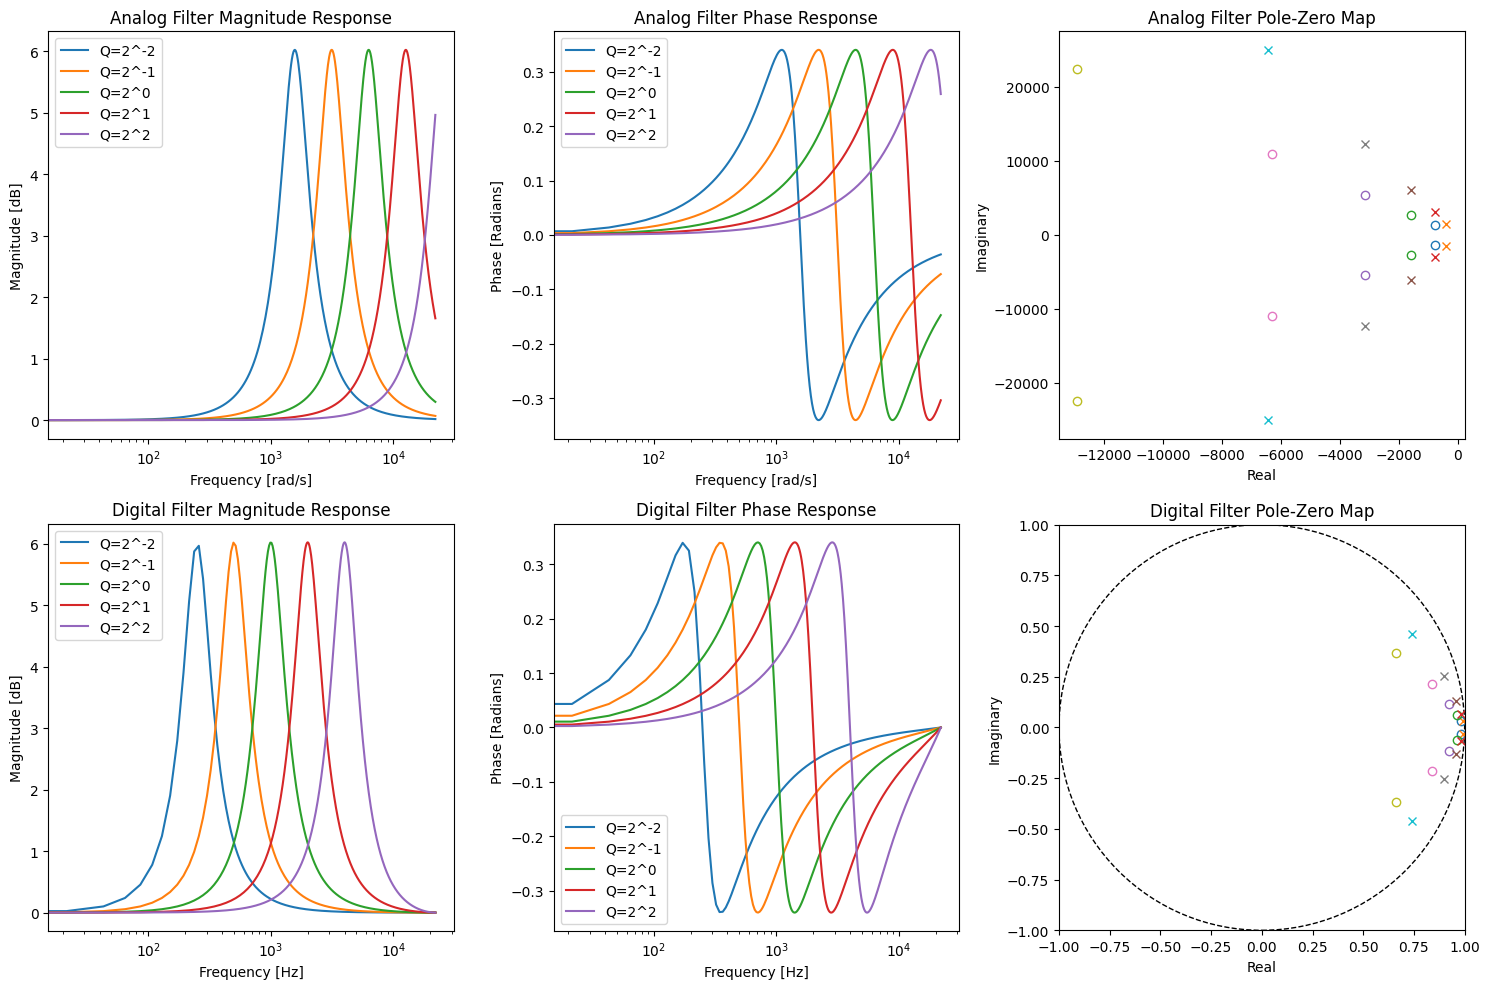

In [ ]:
plt.figure(figsize=(15, 10))
M = np.arange(-2,3)
# Loop through each value of Q, defined as 2
for n in M:
    Q = 2
    wc = 2 * np.pi * 1000 * (2.**n)  # Cutoff frequency in radians/sec
    gamma = 2.  # Gain

    # Prewarp the cutoff frequency
    wc_pre_warped = (2 * fs) * np.tan(wc / (2 * fs))

    # Define the analog filter coefficients
    b = np.array([1./(wc_pre_warped*wc_pre_warped), gamma/(Q*wc_pre_warped), 1.])
    a = np.array([1./(wc_pre_warped*wc_pre_warped), 1.0/(Q*wc_pre_warped), 1.])

    # Compute the analog filter frequency response
    w, H = sig.freqs(b, a, worN=np.linspace(0, fs/2, NFFT))

    # Compute poles and zeros for the analog filter
    z = np.roots(b)
    p = np.roots(a)

    # Convert analog filter coefficients to digital using the bilinear transform
    bz, az = sig.bilinear(b, a, fs)

    # Compute the digital filter frequency response
    wz, Hz = sig.freqz(bz, az, worN=NFFT)

    # Compute poles and zeros for the digital filter
    zz = np.roots(bz)
    pz = np.roots(az)

    # Plot the magnitude response of the analog filter
    plt.subplot(2, 3, 1)
    plt.plot(w, 20 * np.log10(np.abs(H)), label=f'Q=2^{n}')
    plt.xscale('log')
    plt.title('Analog Filter Magnitude Response')
    plt.xlabel('Frequency [rad/s]')
    plt.ylabel('Magnitude [dB]')
    plt.legend()

    # Plot the phase response of the analog filter
    plt.subplot(2, 3, 2)
    plt.plot(w, np.angle(H), label=f'Q=2^{n}')
    plt.xscale('log')
    plt.title('Analog Filter Phase Response')
    plt.xlabel('Frequency [rad/s]')
    plt.ylabel('Phase [Radians]')
    plt.legend()

    # Plot the pole-zero map of the analog filter
    plt.subplot(2, 3, 3)
    plt.plot(np.real(z), np.imag(z), 'o', markerfacecolor="none")
    plt.plot(np.real(p), np.imag(p), 'x')
    plt.title('Analog Filter Pole-Zero Map')
    plt.xlabel('Real')
    plt.ylabel('Imaginary')

    # Plot the magnitude response of the digital filter
    plt.subplot(2, 3, 4)
    plt.plot(wz * (fs / (2 * np.pi)), 20 * np.log10(np.abs(Hz)), label=f'Q=2^{n}')
    plt.xscale('log')
    plt.title('Digital Filter Magnitude Response')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude [dB]')
    plt.legend()

    # Plot the phase response of the digital filter
    plt.subplot(2, 3, 5)
    plt.plot(wz * (fs / (2 * np.pi)), np.angle(Hz), label=f'Q=2^{n}')
    plt.xscale('log')
    plt.title('Digital Filter Phase Response')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Phase [Radians]')
    plt.legend()

    # Plot the pole-zero map of the digital filter
    plt.subplot(2, 3, 6)
    plt.plot(np.real(zz), np.imag(zz), 'o', markerfacecolor="none")
    plt.plot(np.real(pz), np.imag(pz), 'x')
    plt.title('Digital Filter Pole-Zero Map')
    plt.xlabel('Real')
    plt.ylabel('Imaginary')

# Plot the unit circle for the digital filter
ax = plt.subplot(2, 3, 6)
unit_circle = plt.Circle((0, 0), 1, color='black', fill=False, linestyle='--')
ax.add_artist(unit_circle)
ax.set_aspect('equal', 'box')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])



# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

Q1 (c) graph with prewarping

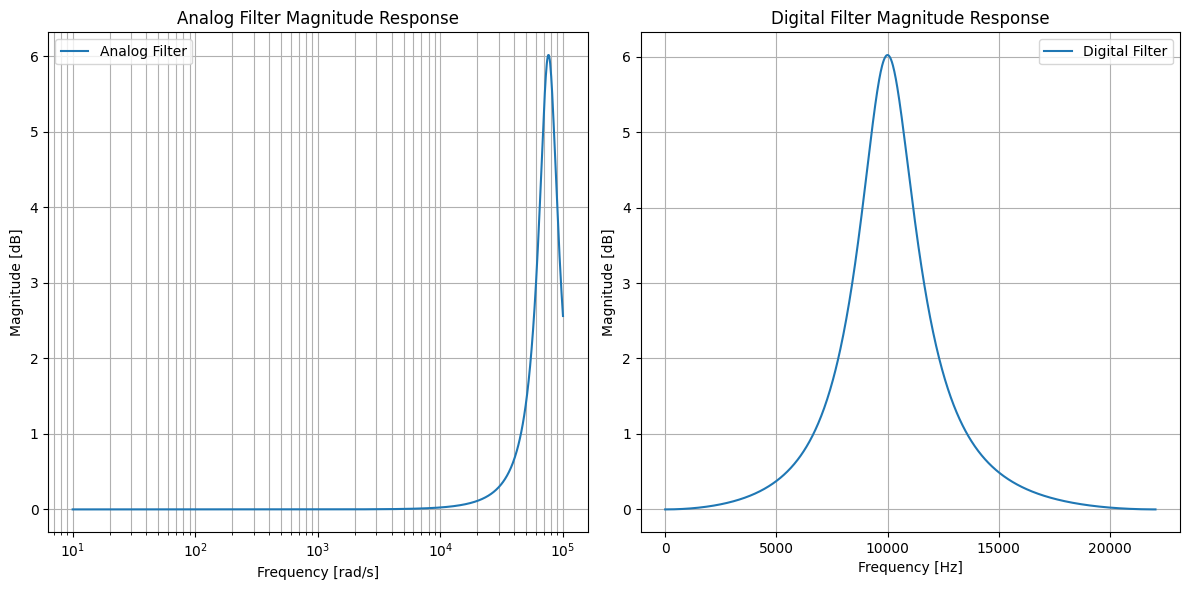

In [ ]:
# Define the filter parameters
Q = 3
wc = 10000
gamma = 2
fs = 44100

my_filter = Filter(fc=wc, gain=gamma, q=Q, fs=fs, filterType='RBPF')

# Analog coefficients with prewarping manually
omega_c = 2 * np.pi * wc
T = 1/fs
omega_c_warped = (2/T) * np.tan(omega_c * T/2)
if np.abs(gamma) >= 1.:
    Bs_analog = np.array([1 / (omega_c_warped ** 2), gamma / (Q * omega_c_warped), 1])
    As_analog = np.array([1 / (omega_c_warped ** 2), 1 / (Q * omega_c_warped), 1])
else:
    Bs_analog = np.array([1 / (omega_c_warped ** 2), 1 / (Q * omega_c_warped), 1])
    As_analog = np.array([1 / (omega_c_warped ** 2), 1 / (Q * gamma * omega_c_warped), 1])

# Frequency response for the analog filter (using recalculated coefficients)
w_analog, H_analog = sig.freqs(Bs_analog, As_analog, worN=np.logspace(1, 5, 1000))

# Frequency response for the digital filter (using coefficients from the Filter instance)
w_digital, H_digital = sig.freqz(my_filter.B, my_filter.A, worN=np.linspace(0, np.pi, 1000))

plt.figure(figsize=(12, 6))

# Analog filter plot
plt.subplot(1, 2, 1)
plt.semilogx(w_analog, 20 * np.log10(abs(H_analog)), label='Analog Filter')
plt.title('Analog Filter Magnitude Response')
plt.xlabel('Frequency [rad/s]')
plt.ylabel('Magnitude [dB]')
plt.grid(which='both', axis='both')
plt.legend()

# Digital filter plot
plt.subplot(1, 2, 2)
frequencies_digital = w_digital * fs / (2 * np.pi)
plt.plot(frequencies_digital, 20 * np.log10(abs(H_digital)), label='Digital Filter')
plt.title('Digital Filter Magnitude Response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid(which='both', axis='both')
plt.legend()

plt.tight_layout()
plt.show()

Q1 (c) graph without prewarping

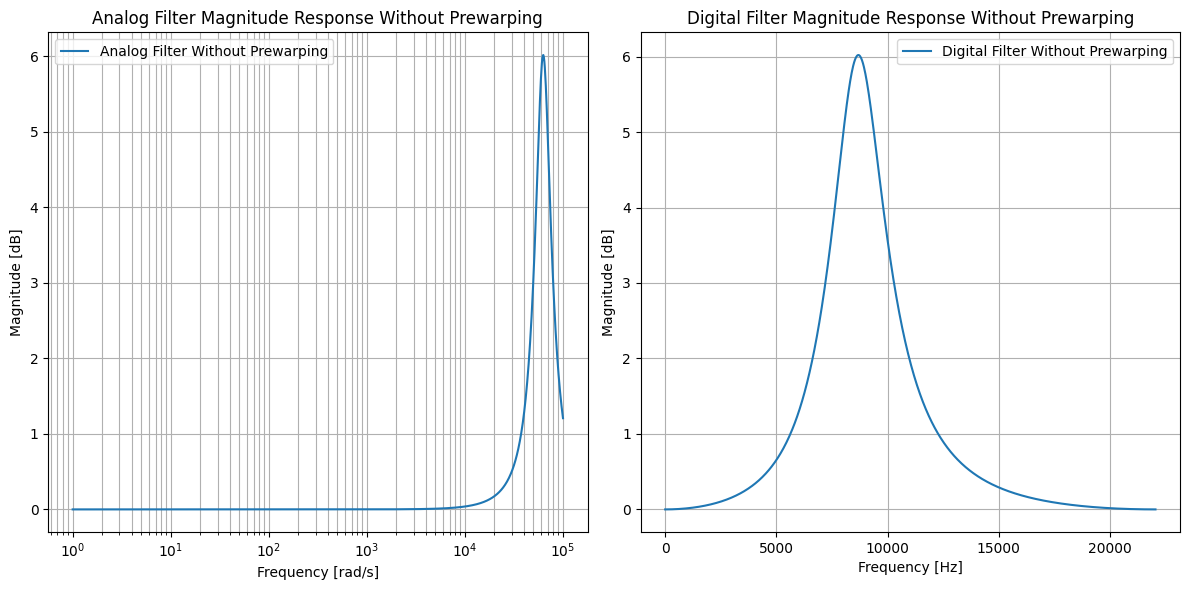

In [ ]:
# Define the filter parameters
Q_no_warp = 3
wc_no_warp = 10000
gamma_no_warp = 2
fs_no_warp = 44100

# Coefficient for non-prewarping manually
omega_c_no_warp = 2 * np.pi * wc_no_warp
b_analog_no_warp = np.array([1 / (omega_c_no_warp ** 2), gamma_no_warp / (Q_no_warp * omega_c_no_warp), 1])
a_analog_no_warp = np.array([1 / (omega_c_no_warp ** 2), 1 / (Q_no_warp * omega_c_no_warp), 1])

# Calculate frequency response for the analog filter
w_analog_no_warp, H_analog_no_warp = sig.freqs(b_analog_no_warp, a_analog_no_warp, worN=np.logspace(0, 5, 1000))

# Convert analog filter coefficients to digital coefficients
bz_digital_no_warp, az_digital_no_warp = sig.bilinear(b_analog_no_warp, a_analog_no_warp, fs_no_warp)

# Calculate frequency response for the digital filter
w_digital_no_warp, H_digital_no_warp = sig.freqz(bz_digital_no_warp, az_digital_no_warp, worN=np.linspace(0, np.pi, 1000))

# Plot the magnitude response
plt.figure(figsize=(12, 6))

# Analog filter plot without prewarping
plt.subplot(1, 2, 1)
plt.semilogx(w_analog_no_warp, 20 * np.log10(abs(H_analog_no_warp)), label='Analog Filter Without Prewarping')
plt.title('Analog Filter Magnitude Response Without Prewarping')
plt.xlabel('Frequency [rad/s]')
plt.ylabel('Magnitude [dB]')
plt.grid(which='both', axis='both')
plt.legend()

# Digital filter plot without prewarping
plt.subplot(1, 2, 2)
frequencies_digital_no_warp = w_digital_no_warp * fs_no_warp / (2 * np.pi)
plt.plot(frequencies_digital_no_warp, 20 * np.log10(abs(H_digital_no_warp)), label='Digital Filter Without Prewarping')
plt.title('Digital Filter Magnitude Response Without Prewarping')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid(which='both', axis='both')
plt.legend()

plt.tight_layout()
plt.show()


Q3 Test with audio file

In [ ]:
!find /content/drive/ -type f -name "Drumset Noise at 4kHz.wav"

In [157]:
import os
os.chdir("/content/drive/MyDrive/DST_SP04/hw1")
# change my current working directory
print(os.getcwd())

# make sure audio file is in directory
print(os.path.exists("noisy.wav"))

/content/drive/MyDrive/DST_SP04/hw1
True


In [159]:
import librosa
audio_file_path = 'noisy.wav'
audio, sr = librosa.load(audio_file_path) #sr for sample rate

print("Original:")
Audio(audio, rate=sr)

Original:


In [ ]:
audio_filter = Filter(fc=1500, gain=-10, q=1, fs=sr, filterType='LSF')

In [ ]:
filtered_audio = audio_filter.process(audio)

In [ ]:
print("Filtered:")
Audio(filtered_audio, rate=sr)

Filtered:


In [ ]:
audio_filter_2 = Filter(fc=70, gain=-10, q=1, fs=sr, filterType='HSF')
filtered_audio_2 = audio_filter_2.process(filtered_audio)

print("Filtered 2nd times:")
Audio(filtered_audio_2, rate=sr)

Filtered 2nd times:


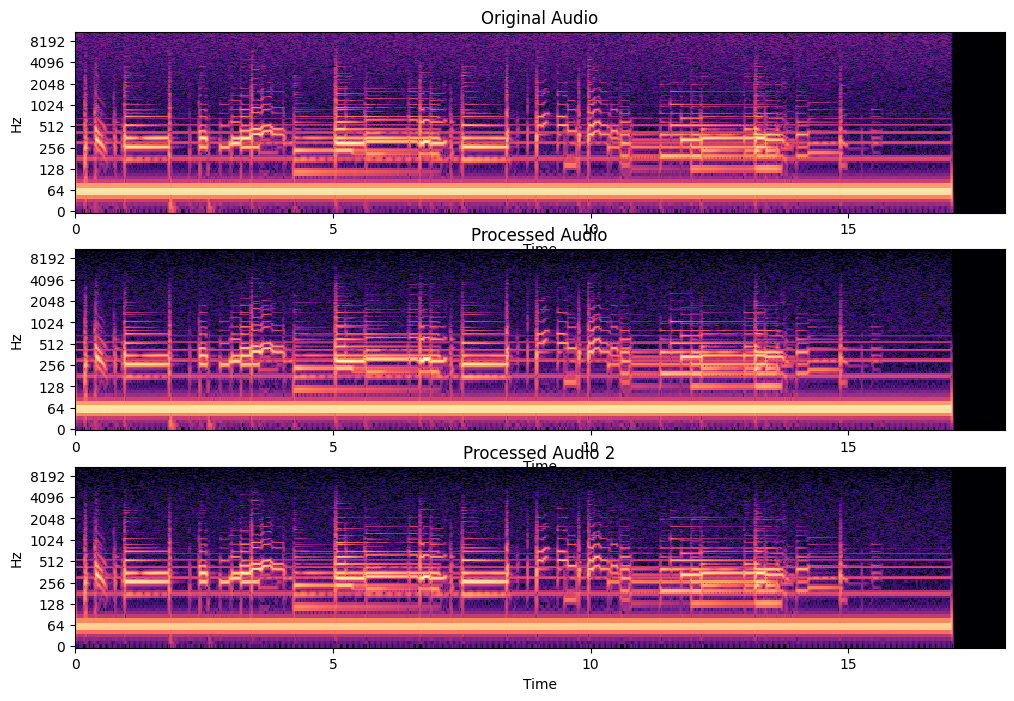

In [153]:
plt.figure(figsize=(12, 8))

# Original audio
plt.subplot(3, 1, 1)
D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.title('Original Audio')

plt.subplot(3, 1, 2)
D = librosa.amplitude_to_db(np.abs(librosa.stft(filtered_audio)), ref=np.max)
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.title('Processed Audio')

plt.subplot(3, 1, 3)
D = librosa.amplitude_to_db(np.abs(librosa.stft(filtered_audio_2)), ref=np.max)
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.title('Processed Audio 2')


plt.show()